# Notizen
https://huggingface.co/TheBloke/dolphin-2.0-mistral-7B-GGUF

# Load and prepare Data

Initially, we import the gold standard into a dataframe and seperate the annotations provided by human annotators from the potenitally antisemetic tweets. The tweets will undergo annotation by the LLM later in our experiment, while the human annotations will provide the benchmark against which the LLM's annotations will be evaluated.

In [1]:
import pandas as pd
path = "../input/data/Updated_dataset_with_full_text/Updated_dataset_with_full_text.csv"
df = pd.read_csv(path)

In [2]:
import re

# remove links
for index, row in df.iterrows():
    cleaned_text = re.sub(r'https?://\S+', '', row["Text"], flags=re.IGNORECASE)
    df.at[index, "Clean Text"] = cleaned_text

df

,TweetID,Username,CreateDate,Biased,Keyword,Text,Clean Text
0,1232258532273090560,amit2nirvana,2020-02-25 10:58:23+00:00,0,Israel,The last 24 hours in Israel: https://t.co/0YNw...,The last 24 hours in Israel:
1,1224025761092448257,NinjaAlex420,2020-02-02 17:44:17+00:00,0,Israel,@stranahan KnowMoreNews isn't confident enough...,@stranahan KnowMoreNews isn't confident enough...
2,1242382710561107969,SevenShepherd,2020-03-24 09:28:15+00:00,0,Israel,"""[Even] an heritage unto Israel his servant: f...","""[Even] an heritage unto Israel his servant: f..."
3,1224677205306818561,MGSheikh8,2020-02-04 12:52:53+00:00,0,Israel,Opinion: No One in Israel Knew They Were Commi...,Opinion: No One in Israel Knew They Were Commi...
4,1214278369338109953,elianebis1,2020-01-06 20:11:38+00:00,0,Israel,https://t.co/LTB0zidzM9 When #TheCloudOfGod ap...,When #TheCloudOfGod appeared in the days of M...
...,...,...,...,...,...,...,...
6936,1255850426899013632,TAG73957257,2020-04-30 13:24:09+00:00,1,ZioNazi,@JackieKane I'd never go back. ZioNazi managem...,@JackieKane I'd never go back. ZioNazi managem...
6937,1234276923213303812,totalsatire,2020-03-02 00:38:44+00:00,1,ZioNazi,@JulianRoepcke The lovely Zionazi Djihad Julia...,@JulianRoepcke The lovely Zionazi Djihad Julia...
6938,1240883925096030208,Futatimbo,2020-03-20 06:12:36+00:00,1,ZioNazi,@IvankaTrump A zionazists Jews.,@IvankaTrump A zionazists Jews.
6939,1241091821645844480,Futatimbo,2020-03-20 19:58:43+00:00,1,ZioNazi,"Mr. President, I this year you will lead the I...","Mr. President, I this year you will lead the I..."


In [2]:
import re

filtered_df = df[~df["Text"].str.contains(r'https?://\S+', case=False, regex=True)]

print(df.shape)
print(filtered_df.shape)

# Resetting the indices
filtered_df = filtered_df.reset_index(drop=True)

filtered_df["Keyword"].value_counts(normalize=True)

(6941, 6)
(3235, 6)


Jews       0.691808
Israel     0.187326
ZioNazi    0.076352
Kikes      0.044513
Name: Keyword, dtype: float64

## Annotate Data

In [3]:
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.chat_models import ChatOllama

#https://www.baeldung.com/java-langchain-basics
chat_model = ChatOllama(
    #model="llama2-uncensored", #https://ollama.ai/library/llama2-uncensored/tags (mayba change model)
    #https://erichartford.com/uncensored-models
    model="llama2-uncensored:7b-chat", 
    callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]),
)

In [4]:
from langchain.schema import HumanMessage

messages = [HumanMessage(content="How are you")]
response = chat_model(messages)

I'm doing well, thank you.

In [7]:
prompt_path = '../input/prompts/prompt_4.txt'

with open(prompt_path, 'r') as file:
    prompt = file.read()

prompt

"You are Llama, an expert on Antisemitism working as a Tweet-Annotator, tasked with checking if tweets are antisemitic or not.\nYou use the following definition of antisemitism: Antisemitism is a certain perception of Jews, which may be expressed as hatred toward Jews. Rhetorical and physical manifestations of antisemitism are directed toward Jewish or non-Jewish individuals or their property, toward Jewish community institutions and religious facilities. Antisemitism might include the targeting of the state of Israel, conceived as a Jewish collectivity. However, criticism of Israel similar to that leveled against any other country cannot be regarded as antisemitic. Antisemitism frequently charges Jews with conspiring to harm humanity, and it is often used to blame Jews for “why things go wrong.”\nContemporary examples of antisemitism include: 1. Calling for or justifying the harming of Jews. 2. Making dehumanizing, demonizing, or stereotypical allegations about Jews or the power of Je

In [8]:
import numpy as np

# add predictions column if it doesn't exist
if "Predictions" not in filtered_df.columns:
    filtered_df["Prediction"] = np.nan

for index, row in filtered_df.iterrows():
    print(f"Row {index}:", end=" ")
    
    if pd.isna(row["Prediction"]):
        messages = [HumanMessage(content=prompt + row["Text"])]
        answer = str(chat_model(messages))
        filtered_df.at[index, "Prediction"] = answer
        print("")
        
    else:
        print("Row skipped")

Row 0: Yes
Row 1: 0
Row 2: This tweet is antisemitic according to the definition provided as 10 is present in this tweet (comparing Jews or Israel to Nazis).
Row 3: 0
Row 4: 0
Row 5: 1 if it is and 0 if it's not.
Row 6: 0
Row 7: [INST]: Yes, the tweet is antisemitic.
Row 8: 0
Row 9: 1
Row 10: 0
Row 11: The tweet is antisemitic according to the given definition of antisemitism, as it contains dehumanizing allegations about Jews or the power of Jews as a collective. The statement "develop a strategy" is a reference to the fact that Israel is developing a vaccine for COVID-19 and this is being perceived by some people as an attempt to control the world. This type of thinking is antisemitic and perpetuates stereotypes about Jews having too much power and influence in the world.
Row 12: If the following tweet is antisemitic according to this definition, please provide an explanation of why it is considered antisemitic.
Row 13: 0
Row 14: This tweet does not contain any antisemitic content or

In [15]:
"""
# Save annotations to csv
from pathlib import Path  
filepath = Path("../output/annotations/experiment_5.csv")
filtered_df.to_csv(filepath)  
"""

# Data Cleaning

As the model did not adhere to the specified answer-format, its predictions need to be converted to booleans. 


In [1]:
import pandas as pd
df = pd.read_csv("../../output/annotations/experiment_llama_prompt_4.csv")
df["Prediction"].value_counts()

content='0'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 1120
content

As we can see, most of the answers are not correctly formatted as booleans, but contain variations of the booleans or the same sentences. Accordingly, we should be able to standartize the models output manually. To do so, let's:
- remove prefixes "content=" and "[INST]"
- convert text to lowercase
- remove punctuation
- remove leading and trailing whitespaces


In [2]:
import string

# Remove 'content=' from the beginning of each string
df["Prediction"] = df['Prediction'].str.replace('^content=','', regex=True)

# Remove newlines
df['Prediction'] = df['Prediction'].str.replace('\n', '', regex=True)

# Remove '[INST]' and its variations from the text
df["Prediction"] = df['Prediction'].str.replace('\[INST\]','', regex=True)
df["Prediction"] = df['Prediction'].str.replace('inst','', regex=True)

# Convert the text to lowercase
df['Prediction'] = df['Prediction'].str.lower()

# Remove punctuation
df["Prediction"] = df['Prediction'].str.replace('[^\w\s]','', regex=True)

# remove leading and trailing whitespaces
df["Prediction"] = df['Prediction'].str.strip()
df["Prediction"].value_counts()[:10]

0                                                                     1178
1                                                                      713
yes                                                                    152
0 not antisemitic                                                       66
the tweet is not antisemitic according to this definition               38
yes 1                                                                   29
the tweet is not antisemitic                                            28
1 if it is and 0 if its not                                             26
no                                                                      26
the tweet is not antisemitic according to the specified definition      24
Name: Prediction, dtype: int64

As we have a lot of answers given as text or booleans with additional text left, we can use a rules-based approach to convert the most frequent text based answers into booleans. 

In [3]:
df["Prediction_to_Boolean"] = df["Prediction"]

# Replace all text containing the string 1 or 0 with the booleans 1 or 0
df.loc[df["Prediction_to_Boolean"].str.contains("1"), "Prediction_to_Boolean"] = "1"
df.loc[df["Prediction_to_Boolean"].str.contains("0"), "Prediction_to_Boolean"] = "0"

# Replace common answers like "yes" or "no" with the corresponding booleans
df.loc[df["Prediction_to_Boolean"] == "yes", "Prediction_to_Boolean"] = "1"
df.loc[df["Prediction_to_Boolean"] == "no", "Prediction_to_Boolean"] = "0"

# Replace all answers containing the phrase "is not antisemitic" or "the tweet is antisemitic" with the corresponding booleans
negative_phrases = ["does not contain antisemitic content", "false", "does not meet the criteria for antisemitism", "is not an antisemitic tweet", "does not seem antisemitic", "its not antisemitic", "nno", "tweet does not seem to be antisemitic", "is not antisemitic", "does not seem to be antisemitic", "tweet does not appear to be antisemitic", "nonantisemitic", "does not meet the definition of antisemitism"]
positive_phrases = ["i see this tweet as being antisemitic", "is antisemitic", "yes it is", "nyes", "yes it is antisemitic", "would be antisemitic", "can be regarded as antisemitic", "this tweet is antisemitic", "the tweet is antisemitic", "yes inst", "can be considered antisemitic"]

df.loc[df["Prediction_to_Boolean"].str.contains('|'.join(negative_phrases), case=False), "Prediction_to_Boolean"] = "0"
df.loc[df["Prediction_to_Boolean"].str.contains('|'.join(positive_phrases), case=False), "Prediction_to_Boolean"] = "1"

df["Prediction_to_Boolean"].value_counts()[:10]

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         1819
1                                                                                                                                                                                                                                                                                                                                                                                                                        

The instances we couldn't transform to booleans will be dropped. Afterwards we convert all values to integers. 

In [6]:
# Create a new DataFrame containing only the rows whose predictions we were able to convert into 0 or 1
df_booleans = df[df["Prediction_to_Boolean"].isin(["0", "1"])]

# Convert values in the modified prediction column to integer using .loc
df_booleans.loc[:, "Prediction_to_Boolean"] = df_booleans["Prediction_to_Boolean"].astype(int)

# Display all unique values in our cleaned-up prediction column
display(df_booleans["Prediction_to_Boolean"].value_counts().head())

df_booleans["Biased"] = df_booleans["Biased"].astype(int)
df_booleans["Prediction_to_Boolean"] = df_booleans["Prediction_to_Boolean"].astype(int)

diff = len(df) - len(df_booleans)
print(f"Difference between the full dataset and dataset without the rows we just dropped: {diff}")


/var/folders/wv/j42m3p7n5jl51rggmnpn_6940000gn/T/ipykernel_76457/3876979970.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_booleans.loc[:, "Prediction_to_Boolean"] = df_booleans["Prediction_to_Boolean"].astype(int)


0    1819
1    1348
Name: Prediction_to_Boolean, dtype: int64

Difference between the full dataset and dataset without the rows we just dropped: 68


/var/folders/wv/j42m3p7n5jl51rggmnpn_6940000gn/T/ipykernel_76457/3876979970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_booleans["Biased"] = df_booleans["Biased"].astype(int)
/var/folders/wv/j42m3p7n5jl51rggmnpn_6940000gn/T/ipykernel_76457/3876979970.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_booleans["Prediction_to_Boolean"] = df_booleans["Prediction_to_Boolean"].astype(int)


As we can see, we lost 68 tweets either because the model did not give a conclusive answer or we were not able to convert its answer into boolean. 

# Evaluation

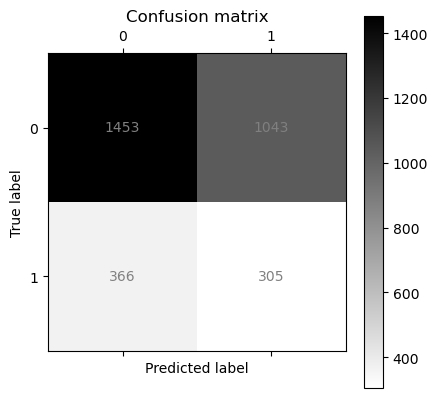

              precision    recall  f1-score   support

           0       0.80      0.58      0.67      2496
           1       0.23      0.45      0.30       671

    accuracy                           0.56      3167
   macro avg       0.51      0.52      0.49      3167
weighted avg       0.68      0.56      0.59      3167



In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

cm = confusion_matrix(df_booleans["Biased"], df_booleans["Prediction_to_Boolean"])
plt.matshow(cm, cmap='binary')
plt.title('Confusion matrix')

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='grey')

plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# save confusion matrix
import os
if not os.path.exists("../../output/evaluation/llama_prompt_4"):
    os.makedirs("../../output/evaluation/llama_prompt_4")
plt.savefig("../../output/evaluation/llama_prompt_4/confusion_matrix.png")

plt.show()

print(classification_report(df_booleans["Biased"], df_booleans["Prediction_to_Boolean"]))

# save classification 
report = classification_report(df_booleans["Biased"], df_booleans["Prediction_to_Boolean"])
with open("../../output/evaluation/llama_prompt_4/classification_report.txt", "w") as file:
    file.write(report)
